In [1]:
!pip install alpaca_trade_api
!pip install cchardet charset_normalizer
import alpaca_trade_api as tradeapi
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

# Helper Function

In [2]:
def moving_average_trading_strategy(data, short_window=12, long_window=48, initial_cash=100000, trade_quantity=1):
    """
    Simulates a trading strategy based on moving averages.

    :param data: DataFrame containing the historical prices.
    :param short_window: Size of the short moving average window.
    :param long_window: Size of the long moving average window.
    :param initial_cash: Initial cash balance to start trading.
    :param trade_quantity: Amount of BTC to buy or sell per trade.
    :return: Tuple containing the BTC holdings over time and PnL percentage series.
    """
    # Calculate short-term and long-term moving averages
    data['Short_MA'] = data['close'].rolling(window=short_window).mean()
    data['Long_MA'] = data['close'].rolling(window=long_window).mean()

    # Initialize variables for tracking trades, cash balance, and BTC holdings over time
    cash_balance = initial_cash
    btc_holding = 0
    btc_holdings_over_time = []
    pnl_percentage_series = []

    # Iterate through the DataFrame to simulate the strategy
    for index, row in data.iterrows():
        if row['Short_MA'] > row['Long_MA'] and cash_balance >= row['close'] * trade_quantity:
            # Buy signal: short MA crosses above long MA
            btc_holding += trade_quantity
            cash_balance -= row['close'] * trade_quantity
        elif row['Short_MA'] < row['Long_MA'] and btc_holding >= trade_quantity:
            # Sell signal: short MA crosses below long MA
            btc_holding -= trade_quantity
            cash_balance += row['close'] * trade_quantity

        btc_holdings_over_time.append(btc_holding)  # Track BTC holding
        total_value = cash_balance + (btc_holding * row['close'])
        pnl_percentage = ((total_value - initial_cash) / initial_cash) * 100  # PnL percentage
        pnl_percentage_series.append(pnl_percentage)

    return btc_holdings_over_time, pnl_percentage_series



In [3]:
def moving_average_trading_strategy_real(curr_data, symbol, short_window=12, long_window=48, initial_cash=100000, trade_quantity=1):
    """
    Determines trading action (buy, sell, or hold) based on moving averages.

    :param curr_data: DataFrame containing the historical prices.
    :param symbol: Symbol of the asset being traded.
    :param short_window: Size of the short moving average window.
    :param long_window: Size of the long moving average window.
    :param initial_cash: Initial cash balance to start trading.
    :param trade_quantity: Amount of the asset to buy or sell per trade.
    :return: Trading action ('buy', 'sell', or 'hold') and the current close price.
    """
    account = api2.get_account()
    cash = float(account.cash)  # Ensure cash is a float
    positions = api2.list_positions()

    # Check if enough quantity of the asset is held for selling
    held_quantity = 0
    for position in positions:
        if position.symbol == symbol:
            held_quantity = float(position.qty)  # Convert quantity to float
            break

    curr_data['Short_MA'] = curr_data['close'].rolling(window=short_window).mean()
    curr_data['Long_MA'] = curr_data['close'].rolling(window=long_window).mean()

    # Get the latest row for decision
    latest_row = curr_data.iloc[-1]

    # Ensure that trade_quantity is a numeric value
    trade_quantity = float(trade_quantity)

    # Determine the trading action
    if latest_row['Short_MA'] > latest_row['Long_MA'] and cash >= latest_row['close'] * trade_quantity:
        # Buy signal: short MA crosses above long MA
        return 'buy', latest_row['close']
    elif latest_row['Short_MA'] < latest_row['Long_MA'] and held_quantity >= trade_quantity:
        # Sell signal: short MA crosses below long MA
        return 'sell', latest_row['close']
    else:
        # Hold signal
        return 'hold', latest_row['close']



In [4]:

def performance_summary(return_data, period=8760):
    """ 
    Returns the Performance Stats for a given set of returns.
    Inputs: 
        return_data - DataFrame with Date index and Daily Returns for different assets/strategies.
    Output:
        summary_stats - DataFrame with annualized mean return, vol, sharpe ratio, skewness, excess kurtosis, 
                        VaR (0.05), CVaR (0.05), and drawdown based on daily returns. 
    """
    summary_stats = return_data.mean().to_frame('Annualized Mean').apply(lambda x: x * period)
    summary_stats['Annualized Volatility'] = return_data.std().apply(lambda x: x * np.sqrt(period))
    summary_stats['Annualized Sharpe Ratio'] = summary_stats['Annualized Mean'] / summary_stats['Annualized Volatility']
    summary_stats['Skewness'] = return_data.skew()
    summary_stats['Excess Kurtosis'] = return_data.kurtosis()
    summary_stats['VaR (0.05)'] = return_data.quantile(.05, axis=0)
    summary_stats['CVaR (0.05)'] = return_data[return_data <= return_data.quantile(.05, axis=0)].mean()
    summary_stats['Min'] = return_data.min()
    summary_stats['Max'] = return_data.max()
    
    wealth_index = 1000 * (1 + return_data).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks) / previous_peaks

    summary_stats['Max Drawdown'] = drawdowns.min()
    summary_stats['Peak'] = [previous_peaks[col][:drawdowns[col].idxmin()].idxmax() for col in previous_peaks.columns]
    summary_stats['Bottom'] = drawdowns.idxmin()
    
    recovery_date = []
    for col in wealth_index.columns:
        prev_max = previous_peaks[col][:drawdowns[col].idxmin()].max()
        recovery_wealth = pd.DataFrame([wealth_index[col][drawdowns[col].idxmin():]]).T
        recovery_date.append(recovery_wealth[recovery_wealth[col] >= prev_max].index.min())
    summary_stats['Recovery'] = recovery_date
    
    return summary_stats



In [5]:
def plot_trading_strategy_results(historical_data, btc_holdings, pnl_series):
    """
    Plots the BTC holdings and PnL percentage from a trading strategy.

    Parameters:
    historical_data (DataFrame): The historical data used for the trading strategy.
    btc_holdings (list): List of BTC holdings over time.
    pnl_series (list): List of PnL percentages over time.
    """
    # Convert the BTC holdings and PnL series to pandas Series
    btc_holdings_series = pd.Series(btc_holdings, index=historical_data.index)
    pnl_percentage_series = pd.Series(pnl_series, index=historical_data.index)

    # Plotting the BTC Holdings Over Time
    plt.figure(figsize=(10, 6))
    plt.plot(btc_holdings_series, label='BTC Holdings')
    plt.xlabel('Date')
    plt.ylabel('BTC Holdings')
    plt.title('BTC Holdings Over Time During Backtest')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plotting the PnL Percentage
    plt.figure(figsize=(10, 6))
    plt.plot(pnl_percentage_series, label='PnL Percentage')
    plt.xlabel('Date')
    plt.ylabel('Profit and Loss (%)')
    plt.title('Backtest PnL Percentage (Cumulative) of Moving Average Strategy')
    plt.legend()
    plt.grid(True)
    plt.show()

In [6]:
def plot_excess_return(excess_return, dates):
    """
    Plots the excess return percentage over time.

    Parameters:
    excess_return (list or Series): List or Pandas Series of excess return values.
    dates (Index or list): Corresponding dates for the excess return values.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(dates, excess_return * 100, label='Excess Return Percentage')
    plt.xlabel('Date')
    plt.ylabel('Excess Return (%)')
    plt.title('Backtest Excess Return of Moving Average Strategy')
    plt.legend()
    plt.grid(True)
    plt.show()

# BackTest

In [7]:
# Set your API key and secret
api_key = 'PKF2ML99Y6WDPK9HK249'
api_secret = 'XkUoctWkCd7YwJOANCbkPE7r7ab3qATr9gnem9TQ'
base_url = 'wss://stream.data.alpaca.markets/v1beta3/crypto/us'  # Use paper trading base URL for testing

# Initialize Alpaca API
api = tradeapi.REST(api_key, api_secret, base_url, api_version='v2')

# Get historical market data
symbol = 'BTC/USD'  # Replace with your desired stock symbol
timeframe = '1H'  # Daily timeframe
start_date = pd.Timestamp("2023-01-01", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2023-12-01", tz="America/New_York").isoformat()


historical_data = api.get_crypto_bars([symbol], 
                                      timeframe, 
                                      start=start_date, 
                                      end=end_date, 
                                      ).df

historical_data

,close,high,low,trade_count,open,volume,vwap,symbol
timestamp,,,,,,,,
2023-01-01 05:00:00+00:00,16522.2900,16526.7100,16503.5500,1449,16513.7000,76.899934,16513.613614,BTC/USD
2023-01-01 06:00:00+00:00,16532.3600,16543.2000,16522.2900,1309,16525.0000,52.083997,16533.304466,BTC/USD
2023-01-01 07:00:00+00:00,16517.7400,16537.4000,16495.0600,2739,16532.9000,194.189437,16515.328375,BTC/USD
2023-01-01 08:00:00+00:00,16507.2100,16526.3800,16502.5700,1260,16520.4200,69.986819,16513.403366,BTC/USD
2023-01-01 09:00:00+00:00,16533.2700,16535.7300,16501.0500,880,16508.3200,48.429349,16518.245031,BTC/USD
...,...,...,...,...,...,...,...,...
2023-12-01 01:00:00+00:00,37933.6360,37963.3315,37658.8565,4,37700.7000,0.008102,37739.150647,BTC/USD
2023-12-01 02:00:00+00:00,37979.5800,38071.7250,37880.3000,6,37961.6485,0.008665,38015.406476,BTC/USD
2023-12-01 03:00:00+00:00,38050.2015,38076.5000,37963.2850,1,38003.9500,0.000026,38076.500000,BTC/USD


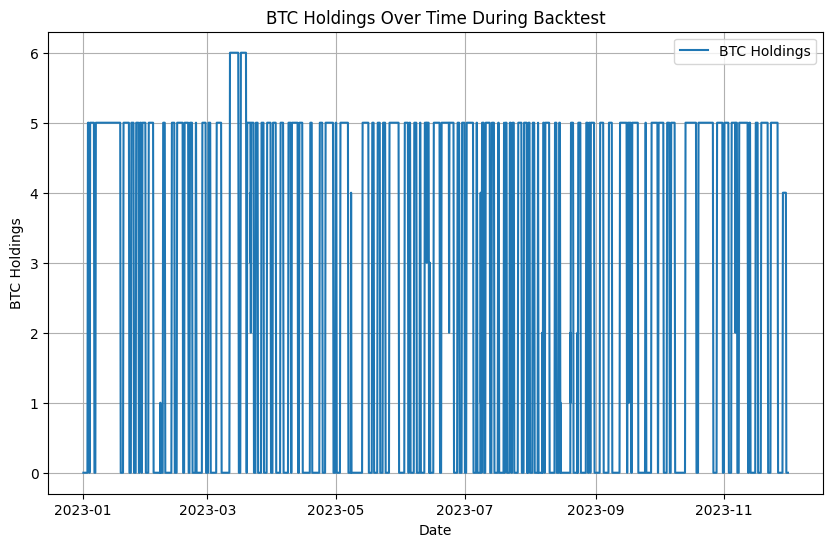

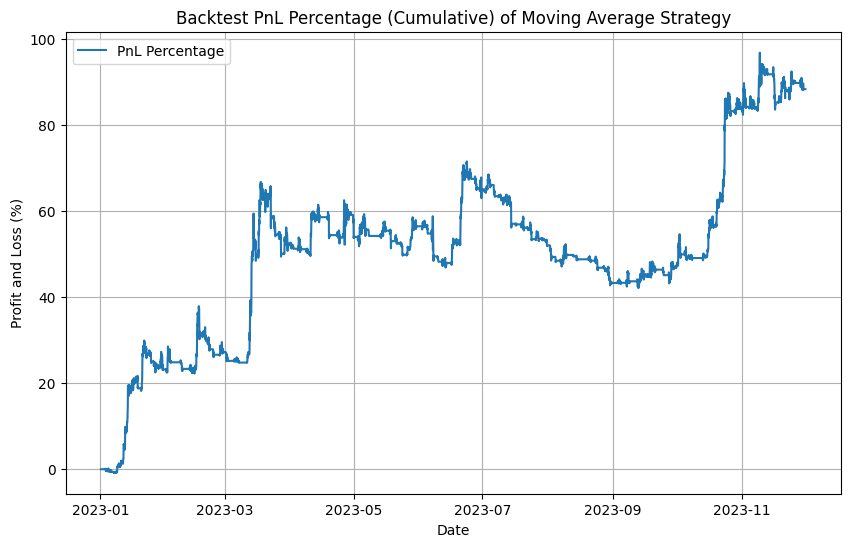

In [8]:
short_window=12
long_window=48
initial_cash=100000
trade_quantity=1

btc_holdings, pnl_series = moving_average_trading_strategy(historical_data)
plot_trading_strategy_results(historical_data, btc_holdings, pnl_series)
historical_data['pnl'] = pnl_series
historical_data['holdings'] = btc_holdings

In [9]:
pnl_series_df = pd.DataFrame(pnl_series, columns=['MA Trading Strategy'])
# Calculate excess return
excess_return = pnl_series_df.diff()/100
# Call the performance_summary function and store the result in a differently named variable
performance_stats = performance_summary(excess_return)
performance_stats

,Annualized Mean,Annualized Volatility,Annualized Sharpe Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Min,Max,Max Drawdown,Peak,Bottom,Recovery
MA Trading Strategy,0.966141,0.469826,2.056378,0.43923,52.795717,-0.005569,-0.011644,-0.092037,0.08452,-0.261231,4164,6114,7097


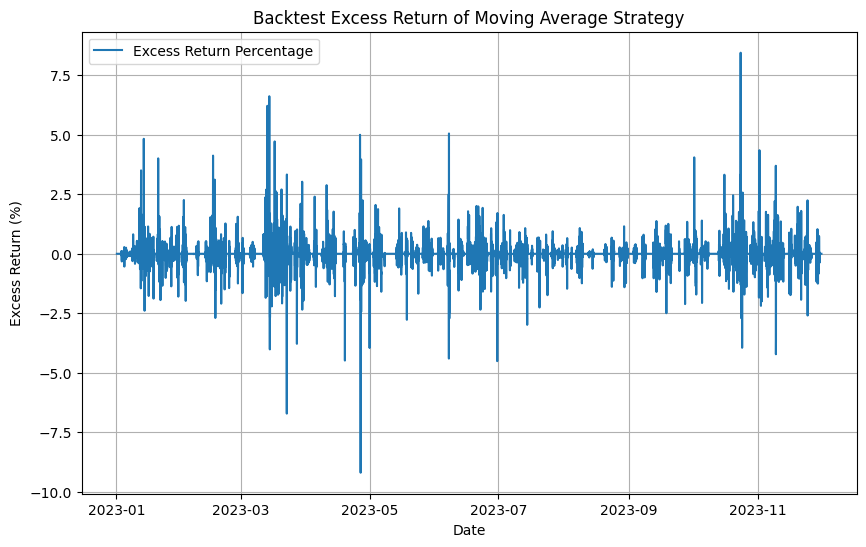

In [10]:
plot_excess_return(excess_return, historical_data.index)

In [12]:
historical_data['pnl'].to_csv('/Users/yiningqu/Desktop/pnl_percentage_series.csv', header=True)

# Convert btc_holdings_series to a CSV file
historical_data['holdings'].to_csv('/Users/yiningqu/Desktop/btc_holdings_series.csv', header=True)

# Convert performance_stats DataFrame to a CSV file

performance_stats.to_csv('/Users/yiningqu/Desktop/performance_stats.csv')


historical_data.to_csv('/Users/yiningqu/Desktop/historical_data.csv')

# RealTime Trading

In [ ]:
# Set your API key and secret
api_key = 'PKF2ML99Y6WDPK9HK249'
api_secret = 'XkUoctWkCd7YwJOANCbkPE7r7ab3qATr9gnem9TQ'
base_url2 = 'https://paper-api.alpaca.markets'  # Corrected base URL for REST API

# Initialize Alpaca API
api2 = tradeapi.REST(api_key, api_secret, base_url2, api_version='v2')

In [ ]:
while True:
    try:
        # Calculate the current time
        current_time = pd.Timestamp.now(tz="America/New_York")

        # Modify start_date: the current time minus the time window of 20 hours
        curr_start_date = (current_time - pd.DateOffset(hours=long_window)).replace(minute=0, second=0, microsecond=0).isoformat()

        # Modify end_date: the current time
        curr_end_date = current_time.replace(minute=0, second=0, microsecond=0).isoformat()

        curr_data = api2.get_crypto_bars([symbol], timeframe, start=curr_start_date, end=curr_end_date).df

        action,close_price = moving_average_trading_strategy_real(curr_data, symbol)

        print(action)
        if action == 'buy':
            # Place Buy order
            api2.submit_order(
                symbol=symbol,
                qty=trade_quantity,  # Adjust quantity as needed
                side='buy',
                type='limit',
                time_in_force='gtc',
                limit_price=close_price * 1.01,  # Place a limit order slightly above the current price
            )
            print("Buy order placed at {}".format(close_price))

        elif action == 'sell':
            # Place Sell order
            api2.submit_order(
                symbol=symbol,
                qty=trade_quantity,  # Adjust quantity as needed
                side='sell',
                type='limit',
                time_in_force='gtc',
                limit_price=close_price * 0.99,  # Place a limit order slightly below the current price
            )
            print("Sell order placed at {}".format(close_price))

        # Wait for the next interval
        time.sleep(3600)

    except Exception as e:
        print(f"An error occurred: {e}")
        # Add proper error handling based on your requirements why still the same problem

hold
hold
hold
hold
